In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import pandas as pd

from statsmodels.api import OLS, add_constant, graphics
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import norm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [2]:
with pd.HDFStore('data/data.h5') as store:
    data = (store['model_data'].dropna().drop(['open', 'close', 'low', 'high'], axis=1))

In [3]:
data = data[data.dollar_vol_rank<100]
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 109675 entries, ('AAL', Timestamp('2013-07-25 00:00:00')) to ('ZTS', Timestamp('2014-12-04 00:00:00'))
Data columns (total 66 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   volume                 109675 non-null  float64
 1   dollar_vol             109675 non-null  float64
 2   dollar_vol_1m          109675 non-null  float64
 3   dollar_vol_rank        109675 non-null  float64
 4   rsi                    109675 non-null  float64
 5   bb_high                109675 non-null  float64
 6   bb_mid                 109675 non-null  float64
 7   bb_low                 109675 non-null  float64
 8   atr                    109675 non-null  float64
 9   macd                   109675 non-null  float64
 10  return_1d              109675 non-null  float64
 11  return_5d              109675 non-null  float64
 12  return_10d             109675 non-null  float64
 13  return_21d    

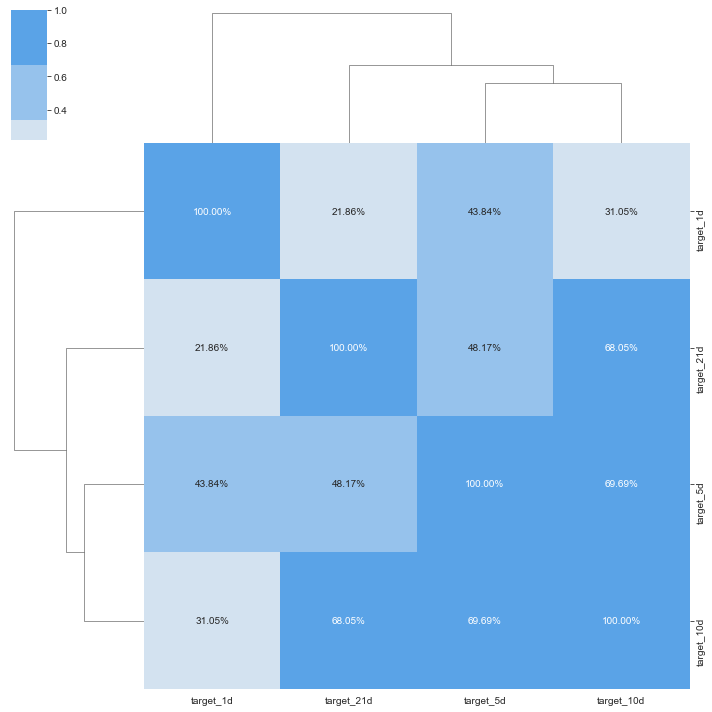

In [24]:
# create features and targets
y = data.filter(like='target') # take columns that include 'target' only
X = data.drop(y.columns, axis=1)
X = X.drop(['dollar_vol', 'dollar_vol_rank', 'volume', 'consumer_durables'], axis=1)
sns.clustermap(y.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=245, l=65), center=0, annot=True, fmt='.2%');

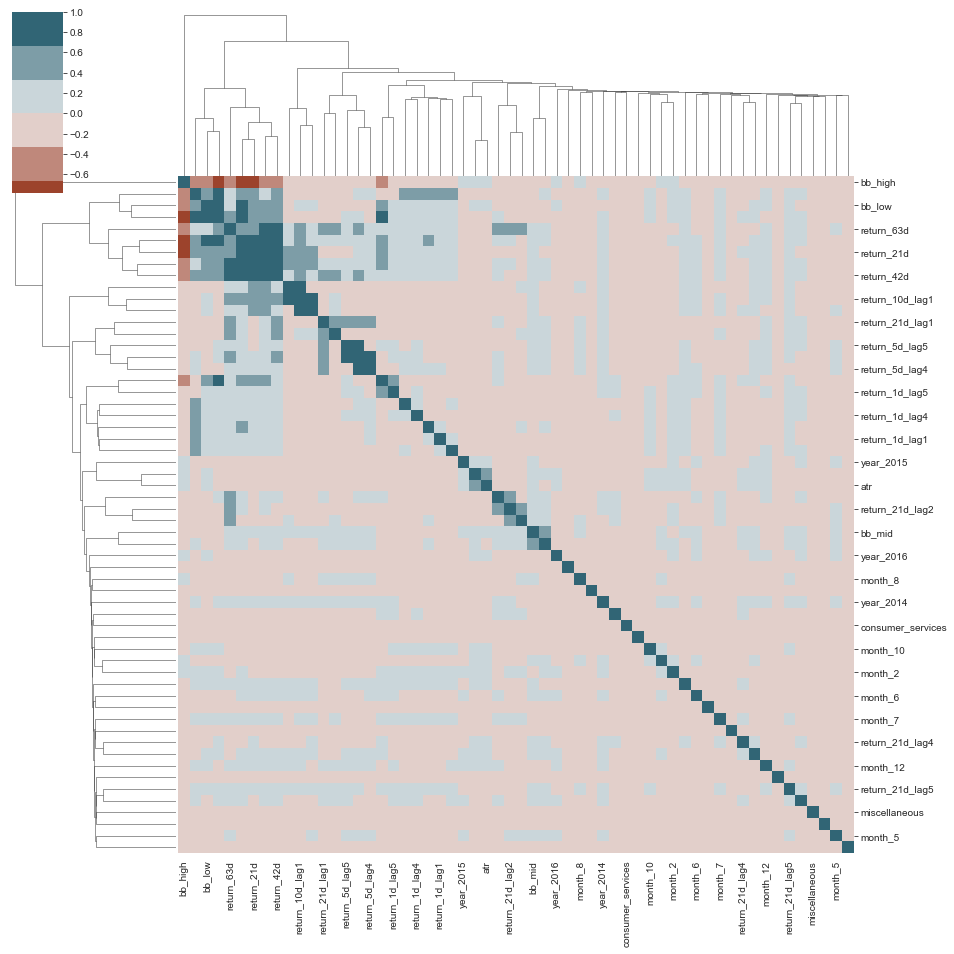

In [42]:
sns.clustermap(X.corr(), cmap=sns.diverging_palette(h_neg=20, h_pos=220, l=40), center=0);
# plt.gcf() : get current figure
plt.gcf().set_size_inches((14, 14))

In [27]:
corr_mat = X.corr().stack().reset_index()
corr_mat.columns=['var1', 'var2', 'corr']
corr_mat = corr_mat[corr_mat.var1!=corr_mat.var2].sort_values(by='corr', ascending=False)
corr_mat.head().append(corr_mat.tail())

,var1,var2,corr
650,return_42d,return_63d,0.835634
707,return_63d,return_42d,0.835634
64,rsi,macd,0.817113
349,macd,rsi,0.817113
586,return_21d,macd,0.793893
126,bb_high,return_21d,-0.632777
125,bb_high,return_10d,-0.693640
524,return_10d,bb_high,-0.693640
60,rsi,bb_high,-0.696555
117,bb_high,rsi,-0.696555


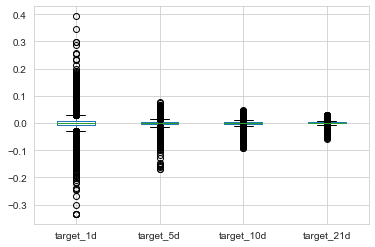

In [9]:
y.boxplot();

In [39]:
X

dollar_vol_1m       rsi   bb_high    bb_mid    bb_low  \
ticker date                                                                
AAL    2013-07-25      -1.377498  1.427605 -0.773214  0.638319  0.535185   
       2013-07-26      -1.308351  1.606301 -0.824760  0.692322  0.589545   
       2013-07-29      -1.257876  1.697656 -0.802774  0.746909  0.595311   
       2013-07-30      -1.257131  1.642956 -0.684236  0.793530  0.550522   
       2013-07-31      -1.175599  1.747786 -0.709213  0.850254  0.527137   
...                          ...       ...       ...       ...       ...   
ZTS    2014-11-28       0.482447  0.789549 -0.697431  0.222654  0.231390   
       2014-12-01       0.925568 -0.628407  0.432822  0.559544 -0.492799   
       2014-12-02       1.043318 -0.187862 -0.963998  0.881192 -0.779983   
       2014-12-03       0.577032 -0.019482 -1.418054  1.145108 -1.041020   
       2014-12-04      -0.830073 -2.259217  0.401583  1.361831 -1.879585   

                        atr      macd  return_1d  return_5d  return_10d  ...  \
ticker date                                                              ...   
AAL    2013-07-25 -0.461161  0.702504   0.639313   0.267036    0.686683  ...   
       2013-07-26 -0.487341  0.784250   0.486606   0.559203    0.710383  ...   
       2013-07-29 -0.560761  0.857554   0.241291   0.701721    0.676785  ...   
       2013-07-30 -0.624026  0.902031  -0.095710   0.750056    0.574837  ...   
       2013-07-31 -0.702416  0.946050   0.259434   0.544923    0.410579  ...   
...                     ...       ...        ...        ...         ...  ...   
ZTS    2014-11-28 -0.457231  0.456081   0.314405   1.766856   -0.136877  ...   
       2014-12-01 -0.419505 -0.181351  -1.004132   0.035205   -0.420698  ...   
       2014-12-02 -0.909876 -0.599807   0.496023  -0.424441   -0.882110  ...   
       2014-12-03 -1.449963 -1.012653   0.120329   0.660102   -0.770513  ...   
       2014-12-04 -1.222688 -2.173507  -1.519309  -1.530273   -0.819365  ...   

                   capital_goods  consumer_non-durables  consumer_services  \
ticker date                                                                  
AAL    2013-07-25              0                      0                  0   
       2013-07-26              0                      0                  0   
       2013-07-29              0                      0                  0   
       2013-07-30              0                      0                  0   
       2013-07-31              0                      0                  0   
...                          ...                    ...                ...   
ZTS    2014-11-28              0                      0                  0   
       2014-12-01              0                      0                  0   
       2014-12-02              0                      0                  0   
       2014-12-03              0                      0                  0   
       2014-12-04              0                      0                  0   

                   energy  finance  health_care  miscellaneous  \
ticker date                                                      
AAL    2013-07-25       0        0            0              0   
       2013-07-26       0        0            0              0   
       2013-07-29       0        0            0              0   
       2013-07-30       0        0            0              0   
       2013-07-31       0        0            0              0   
...                   ...      ...          ...            ...   
ZTS    2014-11-28       0        0            1              0   
       2014-12-01       0        0            1              0   
       2014-12-02       0        0            1              0   
       2014-12-03       0        0            1              0   
       2014-12-04       0        0            1              0   

                   public_utilities  technology  transportation  
ticker date                                      

In [44]:
sectors = X.iloc[:, -10:]
# Ticker-wise standardization
# apply() vs transform(): apply() manipulate all data. Whereas, transform() can control only 1 row or column
X = (X.drop(sectors.columns, axis=1).groupby(level='ticker').transform(lambda x: (x - x.mean()) / x.std())
    .join(sectors).fillna(0))

# 1d returns
target = 'target_1d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_1d   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     21.57
Date:                Sun, 09 Apr 2023   Prob (F-statistic):          3.44e-222
Time:                        15:36:04   Log-Likelihood:             2.8860e+05
No. Observations:              109675   AIC:                        -5.771e+05
Df Residuals:                  109616   BIC:                        -5.765e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

In [45]:
# 5d returns
target = 'target_5d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:              target_5d   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     74.58
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:36:41   Log-Likelihood:             3.7922e+05
No. Observations:              109675   AIC:                        -7.583e+05
Df Residuals:                  109616   BIC:                        -7.578e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

Text(0.5, 0, 'Lags')

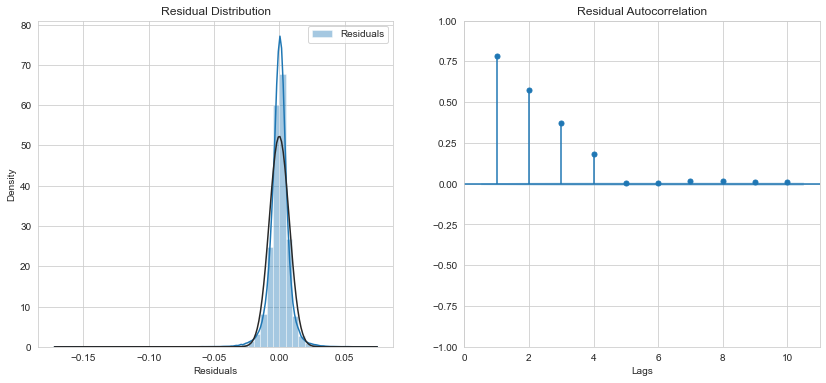

In [56]:
preds = trained_model.predict(add_constant(X))
residuals = y[target] - preds
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
sns.distplot(residuals, fit=norm, ax=axes[0], axlabel='Residuals', label='Residuals')
axes[0].set_title('Residual Distribution')
axes[0].legend()
plot_acf(residuals, lags=10, zero=False, ax=axes[1], title='Residual Autocorrelation')
axes[1].set_xlabel('Lags')

In [57]:
# 10d returns
target = 'target_10d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_10d   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     111.2
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        15:43:35   Log-Likelihood:             4.1968e+05
No. Observations:              109675   AIC:                        -8.392e+05
Df Residuals:                  109616   BIC:                        -8.387e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00

In [14]:
# 21d returns
target = 'target_21d'
model = OLS(endog=y[target], exog=add_constant(X))
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:             target_21d   R-squared:                       0.082
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     168.5
Date:                Sun, 09 Apr 2023   Prob (F-statistic):               0.00
Time:                        02:34:23   Log-Likelihood:             4.6292e+05
No. Observations:              109675   AIC:                        -9.257e+05
Df Residuals:                  109616   BIC:                        -9.252e+05
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.00